## Introduction

## Data extraction and visualisation

In [1]:
import numpy as np
import pandas as pd

import tensorflow_datasets as tfds

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
import keras.backend as K
from keras import optimizers

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

from keras.utils.np_utils import to_categorical

from PIL import Image
from tqdm import tqdm_notebook

from random import randrange


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



Using TensorFlow backend.


The Cats-Vs-Dog data can easily be obtained with the `tensorflow_datasets` library. In the cell below, if `download_data = True`, then tensorflow will download the Cats-Vs-Dog data and store it in the directory `./data`. Otherwise, it will look for the data in the `./data` directory. 

The cell below loads the Cats-Vs-Dog data into the variables `data` and `info`.

In [2]:
download_data = False

if download_data:
    
    data, info = tfds.load('cats_vs_dogs', with_info=True, data_dir='./data')

else:
        
    data, info = tfds.load('cats_vs_dogs', with_info=True, download=False, data_dir='./data')


W0719 15:03:21.077219 140034254001920 deprecation.py:323] From /home/david/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/control_flow_ops.py:423: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


The train/test is all located in `data['train']`. 

In [3]:
image_data = tfds.as_numpy(data['train'])

The images need to be:
* extracted from `image_data.
* converted into black-and-white.
* resized to have dimensions (50, 50).
* normalised by dividing each pixel by 255.
* saved into a a numpy array.

The following cell does exactly this.

In [4]:
dim_resize = (50,50)

X = []
y = []

for image in tqdm_notebook(image_data, total=23262, desc='Resizing Images'):      
    
    img = np.array(image['image'])
    img = Image.fromarray(img)
    img = img.convert('L') 
    img = img.resize(dim_resize)
    
    #img_flipped = img.transpose(Image.FLIP_LEFT_RIGHT)
   
    X.append(np.array(img)/255)
    y.append(image['label'])
   
    #X.append(np.array(img_flipped)/255)
    #y.append(image['label'])
 
  
X = np.array(X)
y = np.array(y)

The shape of the array `X` that contains the image data can be shown.

In [5]:
X.shape

(23262, 50, 50)

In order for the data to be processed more easily by Keras, the array `X` needs to be changed from (23262, 50, 50) to (23262, 50, 50, 1). This is just telling Keras that there is only one colour channel and not the three complete Red Green Blue channels.  

In [6]:
X = X.reshape(len(X), dim_resize[0], dim_resize[1], 1)
X.shape

(23262, 50, 50, 1)

The y array represents the labels for images. Cats have a label of 0 and dogs have a label of 1. It will be more convenient if these labels are changed to `[0]` and `[1]` for cats and dogs respectively. 

In [28]:
y=y.reshape(len(y),1)

In order to test the models that will be constructed, a test dataset that comprises 15% of the data will be set aside. A validation dataset that comprises approxiametly 15% of the *initial* dataset will also be set aside to assess the model's performance during training.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.1765, random_state=0)

To check that the data has been loaded correctly, a random selection of nine of the training data images can be displayed. 

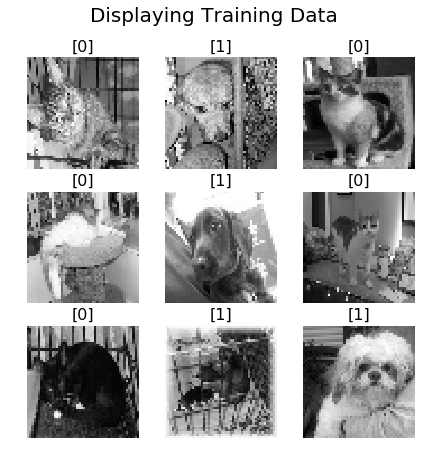

In [48]:
# Obtain a random selection of 9 digit images 
random_indices = [randrange(X_test.shape[0]) for x in range(9)]
X_images = X_test[random_indices]

# Create the figure
fig, ax = plt.subplots(3, 3, figsize=(7,7))
fig.suptitle('Displaying Training Data', fontsize=20)

for i, axis in enumerate(ax.flatten()):
        
    # Obtain the label for this digit
    label = y_test[random_indices[i]]
        
    # Plot the digit and show the prediction
    axis.imshow(X_test[random_indices[i]].reshape(50,50), cmap='gray', interpolation='none')
    axis.set_axis_off()
    axis.set_title(label, fontsize=16)

## First Model

The first model that will be built will be a convolutional neural network. The network will have:
* An initial 10 convolutions of kernel size 6x6. 
* A 2x2 max pooling layer.
* A 0.2 dropout layer.

* A layer of 20 convolutions of kernel size 3x3.
* A 2x2 max pooling layer.
* A 0.2 dropout layer.

* A layer of 30 convolutions of kernel size 2x2.
* A 2x2 max pooling layer.
* A 0.2 dropout layer.

The result of this will be flattened and connected to:

* A dense layer of 20 neurons.
* A 0.2 dropout layer.
* A final dense layer of 1 neuron that corresponds to the binary classification.

All neurons will have the ReLU activation.

The model can be easily constucted using Keras as shown below. 

In [31]:
#MODEL FOR (50,50) 74% Note: sigmoid fully connected last layer. Softmax was not working!?

model = Sequential()


model.add(Conv2D(10, kernel_size=(6,6), activation='relu', input_shape=X_train[0].shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(20, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(30, kernel_size=(2,2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(20, activation='relu'))


model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


W0718 14:47:40.767776 140413220443904 deprecation.py:506] From /home/david/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


A summary of the model can be displayed.

In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 45, 45, 10)        370       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 10)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 22, 10)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 20, 20, 20)        1820      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 20)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 10, 20)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 9, 9, 30)          2430      
__________

The model will use:
* The adam optimizer
* Binary cross entropy as a loss function to guide training
* Accuracy as a metric
* Be trained over 40 epochs

In [33]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [34]:
first_model_output = model.fit(X_train, y_train, epochs=40,  validation_data=(X_validate, y_validate))
first_model = model

Instructions for updating:
Use tf.cast instead.


W0718 14:47:49.231526 140413220443904 deprecation.py:323] From /home/david/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Train on 16282 samples, validate on 3490 samples
Epoch 1/40
16282/16282 [==============================] - 40s 2ms/step - loss: 0.6819 - acc: 0.5531 - val_loss: 0.6702 - val_acc: 0.6057
Epoch 2/40
16282/16282 [==============================] - 38s 2ms/step - loss: 0.6534 - acc: 0.6141 - val_loss: 0.6479 - val_acc: 0.6241
Epoch 3/40
16282/16282 [==============================] - 38s 2ms/step - loss: 0.6375 - acc: 0.6357 - val_loss: 0.6266 - val_acc: 0.6610
Epoch 4/40
16282/16282 [==============================] - 39s 2ms/step - loss: 0.6138 - acc: 0.6652 - val_loss: 0.6284 - val_acc: 0.6266
Epoch 5/40
16282/16282 [==============================] - 40s 2ms/step - loss: 0.5968 - acc: 0.6801 - val_loss: 0.5792 - val_acc: 0.6948
Epoch 6/40
16282/16282 [==============================] - 37s 2ms/step - loss: 0.5791 - acc: 0.6989 - val_loss: 0.5672 - val_acc: 0.7223
Epoch 7/40
16282/16282 [==============================] - 39s 2ms/step - loss: 0.5642 - acc: 0.7076 - val_loss: 0.5422 - val_acc:

The model that has just been trained can be saved for future reference.

In [70]:
first_model.save('./first-model.h5')

For every epoch, both the loss and accuracy for the training data and validation data can be extracted into a Pandas dataframe.

In [49]:
metrics_first = pd.DataFrame(first_model_output.history)

# The index of the metrics dataframe is zero indexed to the epoch number. As such, add one
# to the index so that Epoch 0 becomes Epoch 1.
metrics_first.index = metrics_first.index+1

A function will be created that will plot the accuracy/loss for the training/validation datasets.

In [56]:
def plot_accuracy_loss(df):
    '''The function takes a dataframe that is a Keras model's output history and plots
       the accuracy/loss information for both the training and validation datasets '''
    

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    sns.lineplot(data=df, ax=ax[0], x = df.index, y='acc', label='Training Data')
    sns.lineplot(data=df, ax=ax[0], x = df.index, y='val_acc', label='Validation Data')

    sns.lineplot(data=df, ax=ax[1], x = df.index, y='loss', label='Training Data')
    sns.lineplot(data=df, ax=ax[1], x = df.index, y='val_loss', label='Validation Data')

    fig.suptitle('Accuracy and Loss Across 40 Epochs', fontsize=20)

    ax[0].set_title('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].xaxis.set_major_locator(MultipleLocator(2))
    ax[0].legend()

    ax[1].set_title('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].xaxis.set_major_locator(MultipleLocator(2))
    ax[1].legend()


Having defined the function, it can be called to plot the accuracy and loss for the training and validation datasets across the 20 epochs.


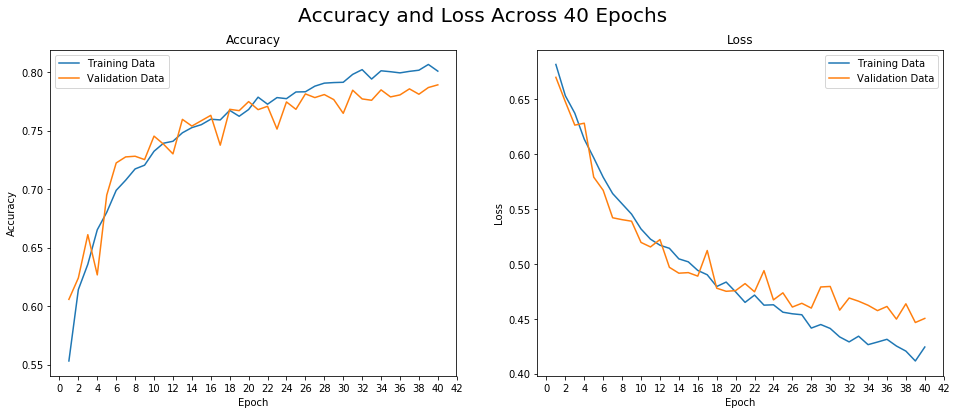

In [57]:
plot_accuracy_loss(metrics_first)

The model can be evaluated on the training data.

In [66]:
first_model.evaluate(X_test, y_test)

3490/3490 [==============================] - 4s 1ms/step


[0.4414191033061391, 0.7936962750716332]

## Second Model

In [58]:
# (50,50) model: 83% accuracy after ~30 epochs. Maybe higher...(probably not)
model = Sequential()

#add model layers
model.add(Conv2D(32, kernel_size=(2,2), activation='relu', input_shape=X_train[0].shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=(2,2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, kernel_size=(2,2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, kernel_size=(2,2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))
#model.add(Dense(1, activation='softmax'))

In [59]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 49, 49, 32)        160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 23, 23, 64)        8256      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 10, 10, 128)       32896     
__________

In [60]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [61]:
second_model_output = model.fit(X_train, y_train, epochs=40,  validation_data=(X_validate, y_validate))
second_model = model

Train on 16282 samples, validate on 3490 samples
Epoch 1/40
16282/16282 [==============================] - 65s 4ms/step - loss: 0.6617 - acc: 0.5928 - val_loss: 0.6088 - val_acc: 0.6607
Epoch 2/40
16282/16282 [==============================] - 66s 4ms/step - loss: 0.5758 - acc: 0.7030 - val_loss: 0.5823 - val_acc: 0.6903
Epoch 3/40
16282/16282 [==============================] - 69s 4ms/step - loss: 0.5353 - acc: 0.7358 - val_loss: 0.5260 - val_acc: 0.7284
Epoch 4/40
16282/16282 [==============================] - 66s 4ms/step - loss: 0.5067 - acc: 0.7532 - val_loss: 0.4808 - val_acc: 0.7705
Epoch 5/40
16282/16282 [==============================] - 63s 4ms/step - loss: 0.4788 - acc: 0.7688 - val_loss: 0.4789 - val_acc: 0.7579
Epoch 6/40
16282/16282 [==============================] - 66s 4ms/step - loss: 0.4586 - acc: 0.7825 - val_loss: 0.4564 - val_acc: 0.7811
Epoch 7/40
16282/16282 [==============================] - 65s 4ms/step - loss: 0.4392 - acc: 0.7966 - val_loss: 0.4315 - val_acc:

The model that has just been trained can be saved for future reference.

In [68]:
second_model.save('./second-model.h5')

For every epoch, both the loss and accuracy for the training data and validation data can be extracted into a Pandas dataframe.

In [64]:
metrics_second = pd.DataFrame(second_model_output.history)

# The index of the dataframe is zero indexed to the epoch number. As such, add one
# to the index so that Epoch 0 becomes Epoch 1.
metrics_second.index = metrics_second.index+1

The accuracy and loss across the 40 epochs can be plotted for the model using the previously defined function `plot_accuracy_loss`. 

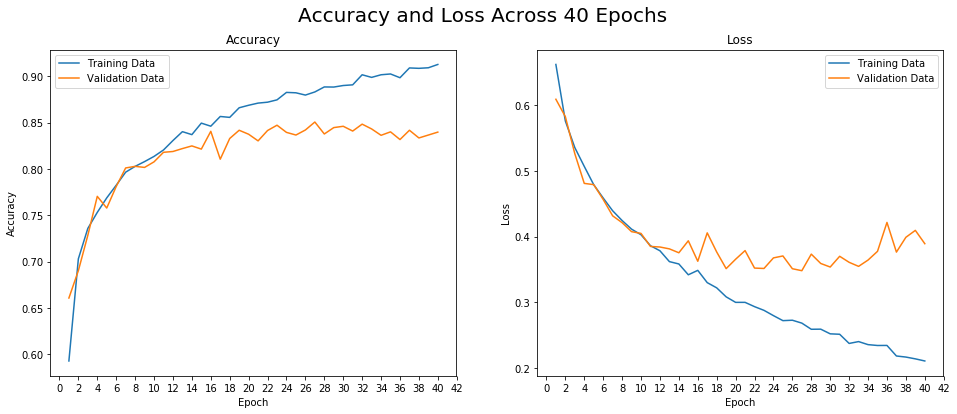

In [65]:
plot_accuracy_loss(metrics_second)

An estimate of the accuracy of the model can be made by taking the mean and standard deviation of the accuracy on the validation data for the epochs 20 through to 40. 

In [73]:
mean = metrics_second['val_acc'][20:40].mean()
std = metrics_second['val_acc'][20:40].std()

print('Accuracy on validation data after overfitting is {:.3f} \u00B1 {:.3f}'.format(mean, std))

Accuracy on validation data after overfitting is 0.840 ± 0.005


In [67]:
second_model.evaluate(X_test, y_test)

3490/3490 [==============================] - 3s 837us/step


[0.3875461269927913, 0.8432664756446991]

In an effort to show what learning the model has made, a display of images versus their predicted labels is shown below for a random selection of the test data.

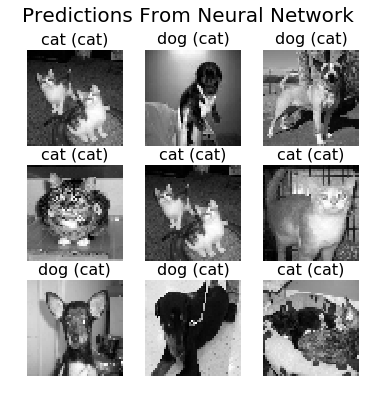

In [99]:
# Obtain a random selection of 9 digit images 
random_indices = [randrange(X_test.shape[0]) for x in range(9)]
X_images = X_test[random_indices]

# Determine the predictions of these 9 images
predictions = second_model.predict(X_images)
predictions = [np.round(x) for x in predictions]

# Determine the actual labels for the images
labels = y_test[random_indices].tolist()

for i, p in enumerate(predictions):
    if p==0:
        predictions[i] = 'cat'
    else:
        predictions[i] = 'dog'
         
for i, l in enumerate(labels):
    if p==[0]:
        labels[i] = 'cat'
    else:
        labels[i] = 'dog'

# Create the figure
fig, ax = plt.subplots(3, 3, figsize=(6,6))
fig.suptitle('Predictions From Neural Network', fontsize=20)

for i, axis in enumerate(ax.flatten()):         
         
        # Plot the digit and show the prediction
        axis.imshow(X_test[random_indices[i]].reshape(50,50), cmap='gray', interpolation='none')
        axis.set_axis_off()
        axis.set_title(str(predictions[i])+' ('+str(labels[i])+')', fontsize=16)
    